**Stack Exchange - Data Scraping for Questions and Tags**

We want to scrape the distributions of numbers of Questions & Tags for the webpage [Stack Echange - ask ubuntu](https://askubuntu.com/) to see if we find anything interesting. To do this, we’ll first scrape data related to Questions and Tags from Stack Exchange webpage for all the respective pages.


**Working out which pages to scrape**

  Once we've defined our goal, we then need to identify an efficient set of pages to scrape. In order to scrape data from the respective web pages, we use the `request` library. A request is what happens when we access a web page. We 'request' the content of a page from the server.

In [1]:
import time
import requests
from requests import get


In [2]:
# Uploading image from local to colab notebook
from google.colab import files
from IPython import display
uploaded = files.upload()

Saving StackEx- askubuntu.jpg to StackEx- askubuntu (1).jpg


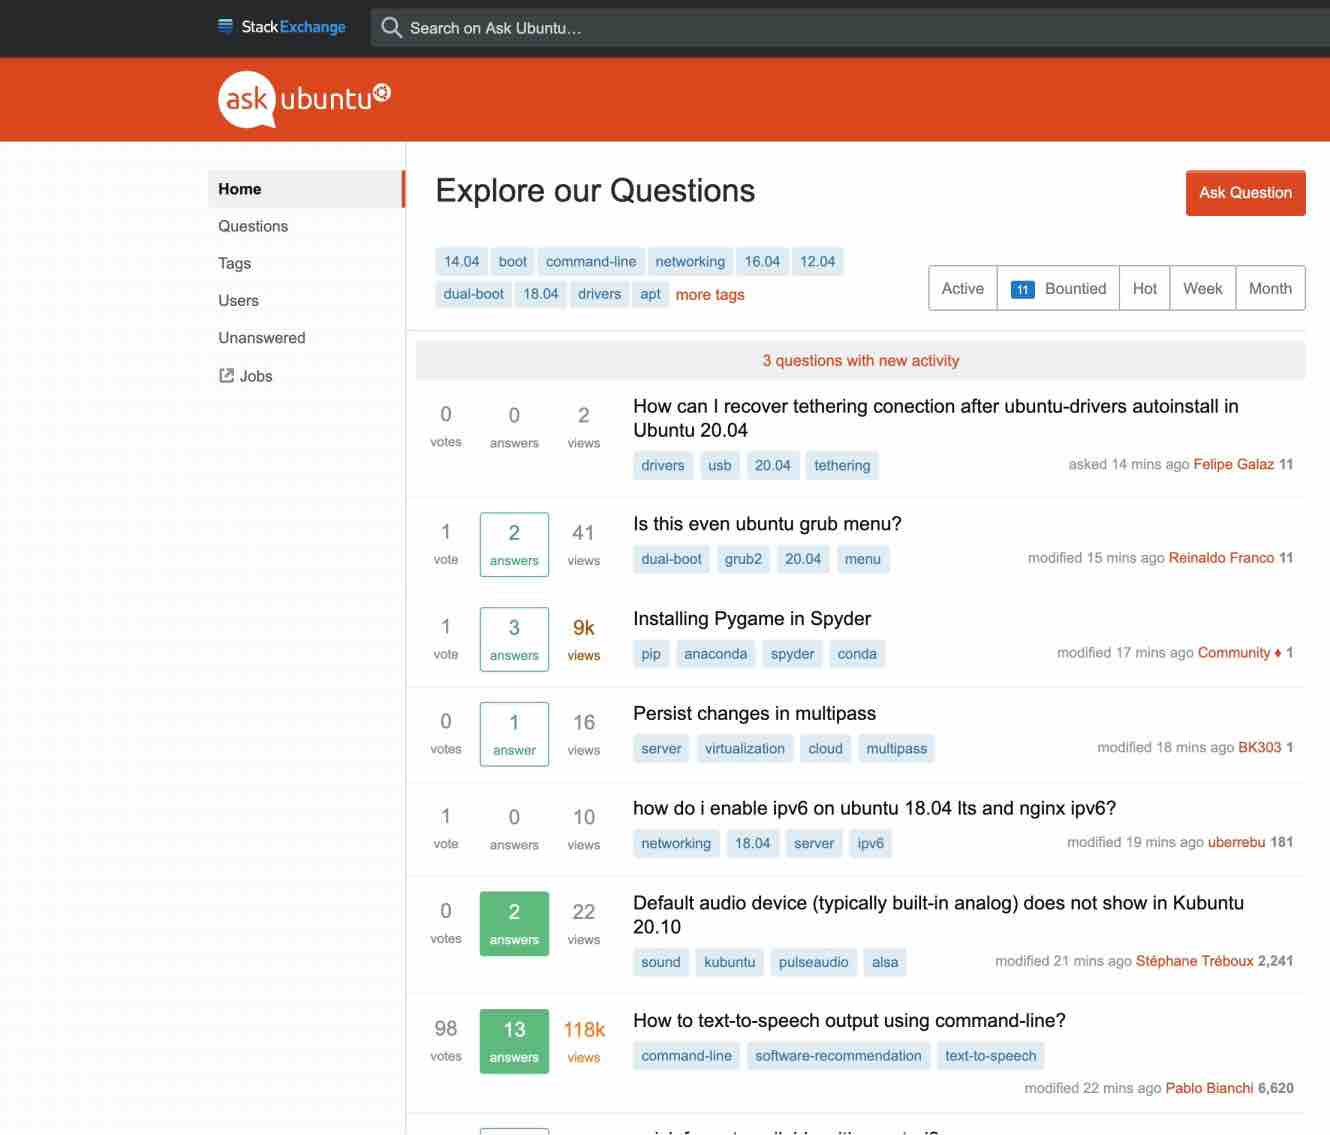

In [3]:
# Reading the image into colab.
display.Image("StackEx- askubuntu.jpg", width=500, height=400)

As we can see that, the home page displays the Questions and Tags together which we want to scrape.

In [4]:
# Importing the get function from the requests module.
from requests import get
url = 'https://askubuntu.com/questions'
time.sleep(5)
# Getting the response from the source URL.
response = get(url)
print(response.text[:500])

<!DOCTYPE html>


    <html class="html__responsive">

    <head>

        <title>Newest Questions - Ask Ubuntu</title>
        <link rel="shortcut icon" href="https://cdn.sstatic.net/Sites/askubuntu/Img/favicon.ico?v=928dfb7c1990">
        <link rel="apple-touch-icon" href="https://cdn.sstatic.net/Sites/askubuntu/Img/apple-touch-icon.png?v=e16e1315edd6">
        <link rel="image_src" href="https://cdn.sstatic.net/Sites/askubuntu/Img/apple-touch-icon.png?v=e16e1315edd6"> 
        <lin


As we can see from the first line of response.text, the server sent us an HTML document. This document describes the overall structure of that web page, along with its specific content (which is what makes that particular page unique).

In [5]:
# Importing the BeautifulSoup class creator from the package bs4 and parsing respose.txt by creating a BeautifulSoup object 
# and assigning it to htlm_soup.

from bs4 import BeautifulSoup
import requests
time.sleep(5)
html_soup = BeautifulSoup(response.text, 'html.parser')


In [6]:
# Printing the total questions summary for each page (pagination set to 50 for viewing purpose)
# The div tag has a class named question-summary that displays to us the entire information for a question posted.

Questions_EachPage = html_soup.find_all('div', class_ = 'question-summary')
print(type(Questions_EachPage))
print(len(Questions_EachPage))

<class 'bs4.element.ResultSet'>
50


As we can see the question summary class count comes out to be 50, which is what we had expected depending on the pagination that we have set.

However, we are only interested to scrape the Questions from this summary and not other things like time, comments, votes, answers,views etc. So, we will only deal with the tag `<h3>` and `<a>`.

**Extracting data for a single question:**


In [7]:
# Printing out the HTLM content of our first question.

first_question = Questions_EachPage[0]
print(first_question)

<div class="question-summary" id="question-summary-1284532">
<div class="statscontainer">
<div class="stats">
<div class="vote">
<div class="votes">
<span class="vote-count-post "><strong>0</strong></span>
<div class="viewcount">votes</div>
</div>
</div>
<div class="status unanswered">
<strong>0</strong>answers
            </div>
</div>
<div class="views " title="7 views">
    7 views
</div>
</div>
<div class="summary">
<h3><a class="question-hyperlink" href="/questions/1284532/how-to-make-initrd-when-building-linux">how to make initrd when building linux?</a></h3>
<div class="excerpt">
            Suppose I want to port arm64 linux to a board(a desktop or server), and the board comes UEFI enabled.
Articles on the web says the bootloader needs kernel image (vmlinux) and initrd. But when I ...
        </div>
<div class="tags t-boot t-grub2 t-kernel t-uefi t-initramfs">
<a class="post-tag" href="/questions/tagged/boot" rel="tag" title="show questions tagged 'boot'">boot</a> <a class="pos

As we can see, the HTML content of one container is very long. To find out the HTML line specific to each data point, we’ll use DevTools once again.

In [8]:

pages_list=[]                         # Empty list that will be appended with the page count

pages_list.append("https://askubuntu.com/questions?tab=newest&pagesize=50")

for page in list(range(2, 301)):     # Looping over all the webpages

  pages_list.append('https://askubuntu.com/questions?tab=newest&page='+str(page))
  
print(len(pages_list))

300


In [9]:

questions_list=[]                     # Creating an empty list of questions that will be appended with the question counts.

for x in pages_list:               # Looping over all the pages in the page list
  page = requests.get(x)
  soup = BeautifulSoup(page.text, 'html.parser')

  question_name = soup.find_all('h3')   # Finding the h3 tag that has details of the question
  for question in question_name:
    if question.find('a'):
      questions_list.append(question.find('a').text)

In [10]:
# Printing the length of the questions scraped and the top 10 questions.
print(len(questions_list))
print(questions_list[:11])

12480
['current community', 'more stack exchange communities', 'how to make initrd when building linux?', 'HDMI not working on Dell XPS 15 with Ubuntu 20.04', 'KDE adding splash screen through internal installer', 'I have a Dell Mini 1010 running lubuntu 18.04', 'Dell Specific Keyboard Layout', 'Download for TL-WN8200ND V2 in kali', 'Ubuntu 20.04.1: How to remove Network file sharing location on Nautilus under other locations', 'Fast battery drain on ASUS VivoBook N552VX with LUKS boot partition', 'Reinstalling Ubuntu 20.04 in place of not working Ubuntu 20.04 (without losing data)']
